In [6]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [7]:
model = torchvision.models.resnet50(pretrained = True)
model.fc = nn.Linear(model.fc.in_features, 5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(448),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/extra'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#class_names = image_datasets['train'].classes


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

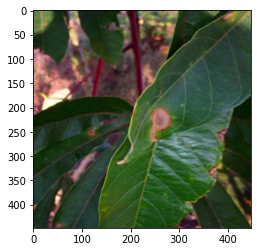

In [9]:
from PIL import Image

sample = (image_datasets['train'][4][0] )

sample = sample.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
sample = std * sample + mean
sample = np.clip(sample, 0, 1)



plt.imshow((sample))

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    losses = np.zeros((2,num_epochs))
    acertos= np.zeros((2,num_epochs))

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

       
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Pon a rede en training mode
            else:
                model.eval()   # Pon a rede en evaluate mode

            running_loss = 0.0
            running_corrects = 0

          
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
              losses[0, epoch]= epoch_loss
              acertos[0, epoch]= epoch_acc
            else:
              losses[1, epoch]= epoch_loss
              acertos[1, epoch]= epoch_acc

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('train loss:', list(losses[0]))
    print()
    print('val loss:', list(losses[1]))
    print()
    print('train acc:', list(acertos[0]))
    print()
    print('val acc:', list(acertos[1]))
    # Cargamos os mellores pesos obtidos ao longo das iteracións
    model.load_state_dict(best_model_wts)
    return model, losses, acertos

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.0005, momentum=0.99)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
model_ft, loss, acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
train Loss: 0.6109 Acc: 0.7880
val Loss: 0.9705 Acc: 0.7000

Epoch 1/1
----------
train Loss: 0.5738 Acc: 0.8080
val Loss: 0.6408 Acc: 0.7833

Training complete in 7m 48s
Best val Acc: 0.783333
train loss: [0.6109176065266934, 0.5737589292881596]

val loss: [0.9704543501138687, 0.6408333430687586]

train acc: [0.7880127298444131, 0.807991513437058]

val acc: [0.7, 0.7833333333333333]


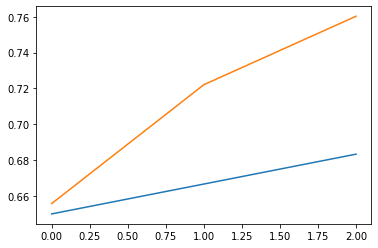

In [18]:
plt.plot(np.arange(0,acc.shape[1],1), acc[1], label='val acc')
plt.plot(np.arange(0,acc.shape[1],1), acc[0], label='train acc')

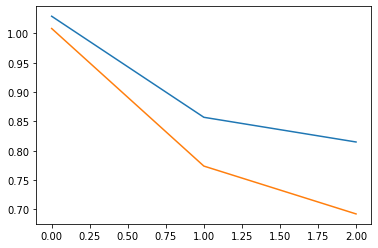

In [20]:
plt.plot(np.arange(0,loss.shape[1],1), loss[1], label='val acc')
plt.plot(np.arange(0,loss.shape[1],1), loss[0], label='train acc')

In [23]:
PATH='./ResNet50-1-extra.h5'

torch.save(model, PATH)

In [ ]:
model = torch.load('/content/drive/My Drive/ResNet50_corrubedo.h5')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transformar = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

from PIL import Image

clases = ['Alytes obstetricans', 'Anguis fragilis', 'Chalcides striatus', 'Chioglossa lusitanica', 'Coronella austriaca', 'Coronella girondica', 'Discoglossus galganoi', 'Emys orbicularis', 'Epidalea calamita', 'Hyla arborea', 'Lacerta schreiberi', 'Lacerta viridis', 'Lissotriton boscai', 'Natrix astreptophora', 'Natrix maura', 'Pelobates cultripes', 'Pelophylax perezi', 'Podarcis bocagei', 'Podarcis hispanicus', 'Rana iberica', 'Salamandra salamandra', 'Timon lepidus', 'Triturus marmoratus', 'Vipera seoanei', 'Zamenis scalaris']
dataset = datasets.ImageFolder('/content/imagen', transform=transformar)
dataloaders = torch.utils.data.DataLoader(dataset)

a=(dataset[0][0] )
a = a.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
a = std * a + mean
a = np.clip(a, 0, 1)

plt.imshow((a))
inputs, outro = next(iter(dataloaders))
inputs = inputs.to(device)
output = model(inputs)
sm = torch.nn.Softmax()
probabilities = sm(output) 
prob, prob2=torch.max(probabilities, 1)
prob=100.*(prob.item())
prob=round(prob, 2)
res = torch.topk(probabilities, 4)
print(clases[int(res.indices[0][0])], ', probabilidade:', prob, '%')
print()
print('Outras posibilidades:')
print()
print(clases[int(res.indices[0][1])], ', probabilidade:', float(res.values[0][1]*100), '%')
print(clases[int(res.indices[0][2])], ', probabilidade:', float(res.values[0][2]*100), '%')
print(clases[int(res.indices[0][3])], ', probabilidade:', float(res.values[0][3]*100), '%')
print()
            